## Medical Image Classification Tutorial with the MedNIST Dataset
#### This tutorial is from the Project-MONAI tutorials found on github: https://github.com/Project-MONAI/tutorials/blob/master/2d_classification/mednist_tutorial.ipynb
 - Create a dataset for training and testing
 - Use MONAI transforms to pre-process data
 - Use DenseNet from MONAI for classification
 - Train the model with PyTorch
 - Evaluate test dataset

In [27]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    EnsureChannelFirst
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.6.0+38.gf6ad4ba5
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f6ad4ba5c2a6ecd8ab0ca18da1c20b0112a18d87

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [28]:
directory = "monai_data/"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

monai_data/


### Download Public Dataset

In [29]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

### Set deterministic training - Important for reproducibility

In [30]:
set_determinism(seed=0)

### Read Image filenames from the dataset folders

In [31]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


### Randomly view images from the dataset and check classes

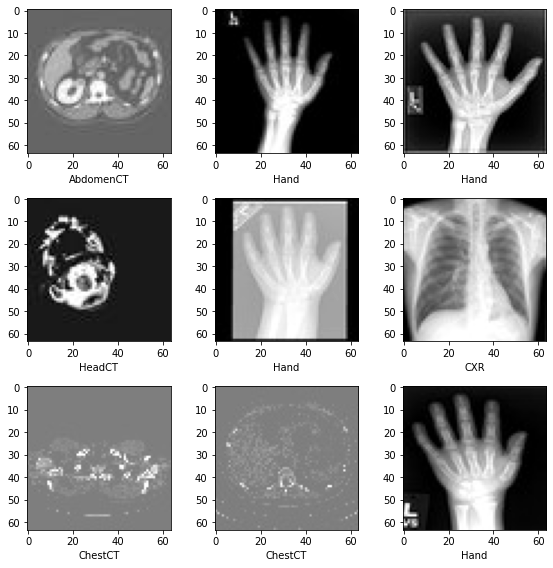

In [32]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### Prepare training, validation and test data lists
 - Randomly select 10% of dataset as validation, 10% as test, 80% as train

In [33]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


### Define MONAI transforms, Dataset and Dataloader to pre-process data

In [34]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(), #Add channel for formatting reasons
        ScaleIntensity(), #Scale intensity of pixels
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), #Randomly rotate image with some probablity
        RandFlip(spatial_axis=0, prob=0.5), #Randomly flip image with some probablity
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5), #Randomly zoom image
        EnsureType(), #Makes sure data is in Tensor format (PyTorch accessible)
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

In [35]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=False, num_workers=4)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300, num_workers=4)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300, num_workers=4)

### Define network and optimizer
    - Set total number of epochs
    - Using DenseNet model
    - Use Adam optimizer

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## We can skip this part since it will take a while without a GPU and look at our results

In [37]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model_MedNIST.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.7958
2/157, train_loss: 1.7556
3/157, train_loss: 1.7410
4/157, train_loss: 1.7047
5/157, train_loss: 1.6856
6/157, train_loss: 1.6540
7/157, train_loss: 1.6378
8/157, train_loss: 1.6039
9/157, train_loss: 1.5781
10/157, train_loss: 1.5430
11/157, train_loss: 1.5277
12/157, train_loss: 1.5139
13/157, train_loss: 1.4916
14/157, train_loss: 1.4468
15/157, train_loss: 1.4535
16/157, train_loss: 1.3985
17/157, train_loss: 1.4012
18/157, train_loss: 1.3821
19/157, train_loss: 1.3977
20/157, train_loss: 1.3453
21/157, train_loss: 1.3597
22/157, train_loss: 1.3130
23/157, train_loss: 1.3094
24/157, train_loss: 1.2837
25/157, train_loss: 1.2465
26/157, train_loss: 1.2062
27/157, train_loss: 1.2019
28/157, train_loss: 1.1878
29/157, train_loss: 1.1939
30/157, train_loss: 1.1500
31/157, train_loss: 1.1500
32/157, train_loss: 1.1162
33/157, train_loss: 1.1063
34/157, train_loss: 1.1166
35/157, train_loss: 1.0918
36/157, train_loss: 1.0799
37/157, train_lo

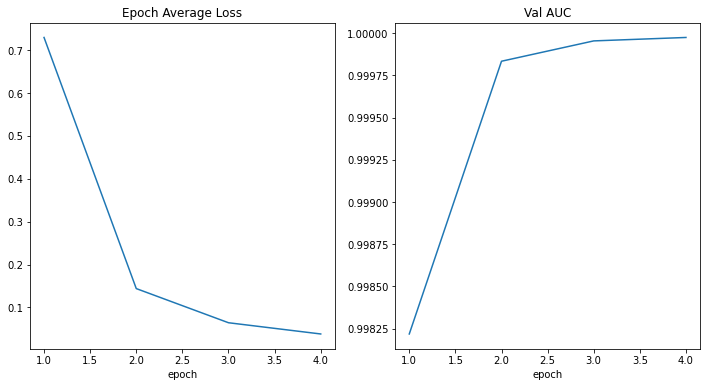

In [38]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Now to evaluate our model on a test dataset

In [41]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_MedNIST.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [42]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9920    0.9960    0.9940       995
   BreastMRI     1.0000    0.9920    0.9960       880
         CXR     0.9990    0.9929    0.9959       982
     ChestCT     0.9961    1.0000    0.9980      1014
        Hand     0.9933    0.9971    0.9952      1048
      HeadCT     0.9969    0.9980    0.9974       976

    accuracy                         0.9961      5895
   macro avg     0.9962    0.9960    0.9961      5895
weighted avg     0.9961    0.9961    0.9961      5895

